### Intro 

MS Studio

When entering a new business, Microsoft has one tradition. Strive for excellence. Our goal with Microsoft Studio is to perpetuate this tradition. 

Every year, thousands of new movies are released. Some are acclaimed by the critics; others are box office success. Our goal is to release movies that are both, critic and box office success. 


### STEP 1 : 

Let's prepare our environment.

In [1]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
!pip install mysql-connector-python

In [2]:
#Connecting SQL

import mysql.connector
con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?', host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com', database = 'movies')
cur = con.cursor()

### STEP 2: 

Let's take a look on this 2x2 matrice of all the movies that were released during the last 10 years.

We will use 2 metrics to evaluate the movies:

- the average rating on IMDB, only for movies with more than 50 ratings
- the Return on Investment (ROI), which is the wordlwide revenue generated by a movie divided by the movie's budget


In [3]:
#Creating df_all from IMDB ratings

cur.execute("""SELECT *
                FROM movies.imdb_title_ratings
                JOIN movies.imdb_title_basics USING(tconst)
                WHERE imdb_title_basics.start_year >= 2010
                AND imdb_title_ratings.numvotes > 50;""")



df_all = pd.DataFrame(cur.fetchall())
df_all.columns = [x[0] for x in cur.description]

# Remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df_all['primary_title'] = df_all['primary_title'].str.replace(char, ' ')
    
#put Title in low caps
df_all['primary_title'] =  df_all['primary_title'].map(lambda x: x.lower())

df_all.head(2)

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,7.00,77,sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0069049,6.90,4517,the other side of the wind,The Other Side of the Wind,2018,122.0,Drama


In [5]:
#Creating df_roi from tn_movie_budgets

df_roi = pd.read_sql_query('select * from tn_movie_budgets', con)
df_roi ["release_date"] = pd.to_datetime(df_roi ["release_date"]) 
df_roi.head()

#Cleaning those 3 columns
df_roi ["production_budget"] = df_roi ["production_budget"].map(lambda x: x.lstrip('$')).str.replace(',','')
df_roi ["domestic_gross"] = df_roi ["domestic_gross"].map(lambda x: x.strip('$,')).str.replace(',','')
df_roi ["worldwide_gross"] = df_roi ["worldwide_gross"].map(lambda x: x.strip('$,')).str.replace(',','')
df_roi = df_roi.astype({"production_budget":'int64', "domestic_gross":'int64',"worldwide_gross":'int64'}) 

#New column roi metrics that show you 
df_roi ["roi"] = (df_roi ["worldwide_gross"])/df_roi ["production_budget"]
df_roi = df_roi.sort_values("roi",ascending = 0)

# Selecting movies after 2000
df_roi['year'] = df_roi['release_date'].apply(lambda x: x.year)
df_roi = df_roi.loc [df_roi['year'] > 2010]

#Rename column
df_roi = df_roi.rename(columns={'movie': 'primary_title'})

# Remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df_roi['primary_title'] = df_roi['primary_title'].str.replace(char, ' ')
    
#put Title in low caps
df_roi['primary_title'] =  df_roi['primary_title'].map(lambda x: x.lower())

#Rename column
df_roi = df_roi.rename(columns={'movie': 'primary_title'})

df_roi.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year
5679,80,2015-07-10,the gallows,100000,22764410,41656474,416.564740,2015
5211,12,2012-01-06,the devil inside,1000000,53262945,101759490,101.759490,2012
5062,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011
5213,14,2015-04-17,unfriended,1000000,32789645,64364198,64.364198,2015
4249,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017


In [6]:
#Left merge between df_roi and df_all
left_join_df = df_roi.merge(df_all, on='primary_title', how='left' )

#Drop if ROI or Rating is NA
left_join_df = left_join_df.dropna(subset = ["averagerating", "roi"])

Text(0, 0.5, 'IMDB Rating')

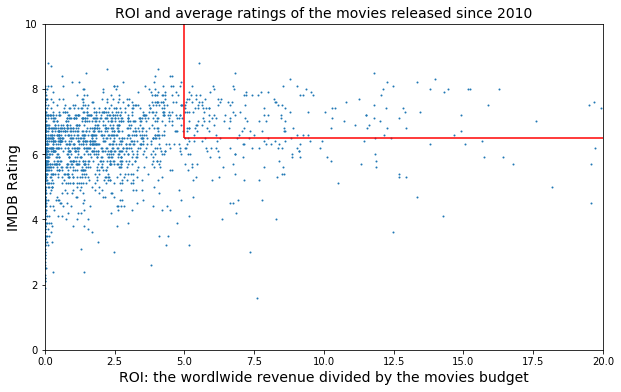

In [40]:
f, ax = plt.subplots(figsize=(10, 6))
plt.scatter(left_join_df['roi'] , left_join_df['averagerating'], marker="o", s=1)
plt.xlim(0, 20)
plt.ylim(0, 10)

plt.hlines(y=6.5, xmin=5, xmax=20, color='red')
plt.vlines(x=5, ymin=6.5, ymax=10, color='red')


plt.title("ROI and average ratings of the movies released since 2010", size=14)
plt.xlabel('ROI: the wordlwide revenue divided by the movies budget', size=14)
plt.ylabel('IMDB Rating', size=14) 

We can see that there are many movies with (1) relatively low IMDB rating and high ROI or (2) relatively high IMDB rating but low ROI.

We belive that Microsoft will not be interested in such movies.

We will focus our presentation on movies that have a ROI over 5 and an average rating > 6.5. 

We call them SUCCESSFUL MOVIES.

### STEP 3: 

Let's check what is the best month to release a successful movie.

Text(0.5, 0, 'Months')

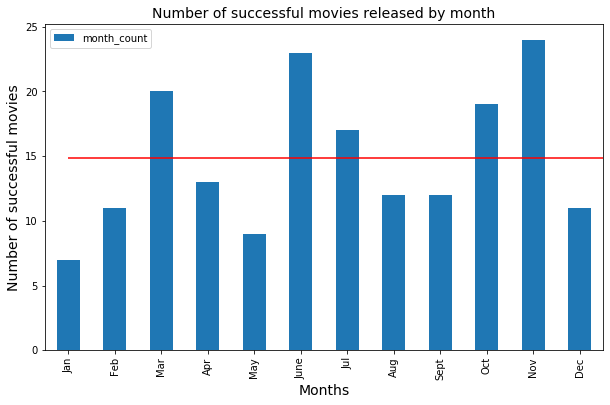

In [35]:
# What's the best month to release a movie?
df_join = left_join_df.loc [left_join_df['averagerating'] > 6.5]
df_join = df_join.loc [df_join ['roi'] > 5]

df_join['month'] = df_join['release_date'].apply(lambda x: x.month)

graph_month = df_join.groupby('month').count().sort_values(by = 'month', ascending = True)
graph_month = graph_month.tconst.reset_index()
graph_month = graph_month.rename(columns={"tconst": "month_count"})
graph_month

#Put month in text instead of number
dic_month = {1 : "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "June", 7:"Jul", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}
graph_month["month"] =graph_month.month.map(dic_month)

# Plot the bar char for graph_month
ax = graph_month.plot(figsize=(10, 6), x='month', y='month_count', kind='bar')
plt.hlines(y= graph_month["month_count"].mean(), xmin=0, xmax=20, color='red')

plt.title("Number of successful movies released by month", size=14, loc='center')
plt.ylabel('Number of successful movies', size=14) 
plt.xlabel('Months', size=14) 

In [27]:
average_production = round(graph_month["month_count"].mean(),2)
print(f'The average number of well performing movies (high ROI) released in a month is {average_production}. \nSome months show higher than average number of successful movies.')

The average number of well performing movies (high ROI) released in a month is 14.83. 
Some months show higher than average number of successful movies.


Based on the above finding, we recommend that Microsoft aims at releasing new movies in months that seem more frequently lead to higher ROI, including: March, June, July, October and November. 

### STEP 4: 

Let's now take a look at the most succesfull genres

In [50]:
#Connecting two lists to dictionary and transforming to DataFrame
#Sorting values by count (sum of all three genre types)

genres_cumulative = {'genres': list_genres, 'genres_count': genres_count}
genres_total = pd.DataFrame.from_dict(genres_cumulative)
genres_total = genres_total.sort_values(by = 'genres_count', ascending = False)

In [47]:
#Calculating mean per genre
genres_mean = round(genres_total["genres_count"].mean(),2)
print(f'The average number of successful movies per category is {genres_mean}') 

The average number of successful movies per category is 31.09


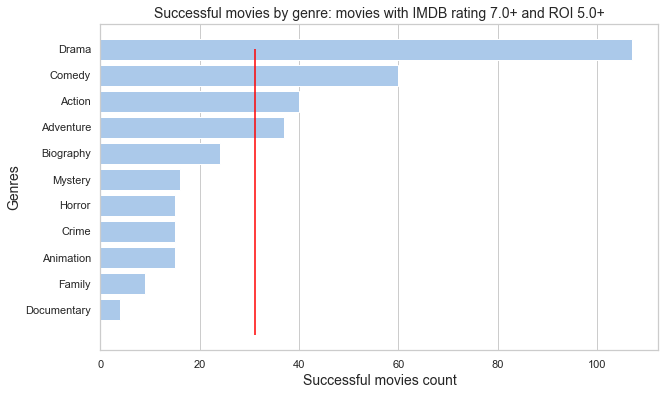

In [54]:
#Plotting graph
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

sns.set_color_codes("pastel")
sns.barplot(x="genres_count", y="genres", data= genres_total,
            label="Successful movies by genres", color="b")
ax.set_xlabel('Successful movies count', size = 14)
ax.set_ylabel('Genres', size = 14)
ax.set_title('Successful movies by genre: movies with IMDB rating 7.0+ and ROI 5.0+', size = 14)

plt.vlines(x= genres_total["genres_count"].mean(), ymin=0, ymax=11, color='red')

Based on the above graph we can conclude that four genres have the larest number of successful movies: 
- Drama, 
- Comedy
- Action
- Adventure

Microsoft should invest in producting movies in one of these four genres. 

### STEP 5: 

Let's now look wich are the most successful directors.

In [4]:
#Importing SQL data (IMDB Ratings)

cur.execute("""SELECT *
                FROM movies.imdb_title_ratings
                JOIN movies.imdb_title_basics USING (tconst)
                JOIN movies.imdb_title_crew USING (tconst)
                LEFT JOIN movies.imdb_name_basics ON movies.imdb_name_basics.nconst = movies.imdb_title_crew.directors
                WHERE imdb_title_basics.start_year >= 2010
                AND imdb_title_ratings.averagerating >6.5
                AND imdb_title_ratings.numvotes > 50;""")

df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df


,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,tt0063540,7.00,77,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276",nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer","tt0266757,tt0266712,tt0134996,tt0266765"
1,tt0069049,6.90,4517,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,"nm0000080,nm0462648",nm0000080,Orson Welles,1915.0,1985.0,"actor,director,writer","tt0048393,tt0052311,tt0057427,tt0033467"
2,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",nm0365480,nm0365480,nm0365480,Anthony Harrison,1961.0,NaN,"actor,writer,producer","tt5615700,tt0298814,tt0137204,tt6461824"
3,tt0146592,6.80,451,Pál Adrienn,Pál Adrienn,2010,136.0,Drama,nm1030585,"nm1030585,nm1921430",nm1030585,Ágnes Kocsis,1971.0,NaN,"director,writer,producer","tt0146592,tt0291503,tt0461424,tt0484487"
4,tt0159369,7.60,53,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,nm0611850,nm0611850,nm0611850,John Mulholland,NaN,NaN,"director,writer,producer","tt6609564,tt0359475,tt0159369,tt4332600"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,tt9904844,8.70,218,Ott Tänak: The Movie,Ott Tänak: The Movie,2019,125.0,Documentary,nm4942142,None,nm4942142,Tarvo Mölder,NaN,NaN,"director,actor","tt7716654,tt1678635,tt3686032"
13517,tt9905412,8.10,505,Ottam,Ottam,2019,120.0,Drama,nm10533890,nm10533895,nm10533890,Zam,NaN,NaN,director,
13518,tt9905462,8.40,600,Pengalila,Pengalila,2019,111.0,Drama,nm0151535,nm0151535,nm0151535,T.V. Chandran,1950.0,NaN,"director,writer,actor","tt0207956,tt0356505,tt0248317,tt0390526"
13519,tt9911774,8.40,365,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,nm10536451,"nm10536451,nm10536453,nm10536454",nm10536451,Vineesh Aaradya,NaN,NaN,"writer,director",


In [5]:
#Renaming director column
df = df.rename(columns={"primary_name": "director_name"})
df.head(5)

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,nconst,director_name,birth_year,death_year,primary_profession,known_for_titles
0,tt0063540,7.00,77,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276",nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer","tt0266757,tt0266712,tt0134996,tt0266765"
1,tt0069049,6.90,4517,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,"nm0000080,nm0462648",nm0000080,Orson Welles,1915.0,1985.0,"actor,director,writer","tt0048393,tt0052311,tt0057427,tt0033467"
2,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",nm0365480,nm0365480,nm0365480,Anthony Harrison,1961.0,NaN,"actor,writer,producer","tt5615700,tt0298814,tt0137204,tt6461824"
3,tt0146592,6.80,451,Pál Adrienn,Pál Adrienn,2010,136.0,Drama,nm1030585,"nm1030585,nm1921430",nm1030585,Ágnes Kocsis,1971.0,NaN,"director,writer,producer","tt0146592,tt0291503,tt0461424,tt0484487"
4,tt0159369,7.60,53,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,nm0611850,nm0611850,nm0611850,John Mulholland,NaN,NaN,"director,writer,producer","tt6609564,tt0359475,tt0159369,tt4332600"


In [6]:
#Grouping top rated movies by directors

top_directors = df.groupby('director_name').count().sort_values(by = 'tconst', ascending = False)
top_directors = top_directors.tconst.reset_index()
top_directors = top_directors.rename(columns={"tconst": "movies_count"})
top_directors = top_directors.loc[top_directors['movies_count'] >= 6]
top_directors_number = len(top_directors)

print(f'There are {top_directors_number} directors who produces 6+ high-rating movies (with IMDB rating 7.0+) over last 10 years' )

There are 45 directors who produces 6+ high-rating movies (with IMDB rating 7.0+) over last 10 years


In [7]:
top_directors.head(10)

,director_name,movies_count
0,Alex Gibney,16
1,Kaushik Ganguly,13
2,Sang-soo Hong,12
3,Cathy Garcia-Molina,11
4,Anjan Dutt,10
5,Hanung Bramantyo,9
6,Srijit Mukherji,9
7,Mahesh Manjrekar,8
8,Lav Diaz,8
9,Paul Dugdale,8


In [8]:
#Extracting ROI data
pd_roi = pd.read_sql_query('select * from tn_movie_budgets', con)
pd_roi ["release_date"] = pd.to_datetime(pd_roi ["release_date"]) 
pd_roi.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [12]:
#Cleaning datapd_roi ["production_budget"] = pd_roi ["production_budget"].map(lambda x: x.lstrip('$')).str.replace(',','')
pd_roi ["domestic_gross"] = pd_roi ["domestic_gross"].map(lambda x: x.strip('$,')).str.replace(',','')
pd_roi ["worldwide_gross"] = pd_roi ["worldwide_gross"].map(lambda x: x.strip('$,')).str.replace(',','')
pd_roi ["production_budget"] = pd_roi ["production_budget"].map(lambda x: x.strip('$,')).str.replace(',','')


pd_roi = pd_roi.astype({"production_budget":'int64', "domestic_gross":'int64',"worldwide_gross":'int64'}) 

#Creating new ROI column 
pd_roi ["roi"] = (pd_roi ["worldwide_gross"])/pd_roi ["production_budget"]
pd_roi = pd_roi.sort_values("roi",ascending = 0)

# Selecting movies after 2000
pd_roi['year'] = pd_roi['release_date'].apply(lambda x: x.year)
pd_roi = pd_roi.loc [pd_roi['year'] > 2010]
pd_roi = pd_roi.loc [pd_roi['roi'] > 5]
pd_roi.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi,year
5679,80,2015-07-10,The Gallows,100000,22764410,41656474,416.564740,2015
5211,12,2012-01-06,The Devil Inside,1000000,53262945,101759490,101.759490,2012
5062,63,2011-04-01,Insidious,1500000,54009150,99870886,66.580591,2011
5213,14,2015-04-17,Unfriended,1000000,32789645,64364198,64.364198,2015
4249,50,2017-01-20,Split,5000000,138141585,278964806,55.792961,2017


In [13]:
pd_roi = pd_roi.rename(columns={'movie': 'primary_title'})

In [14]:
# Remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['primary_title'] = df['primary_title'].str.replace(char, ' ')
    pd_roi['primary_title'] = pd_roi['primary_title'].str.replace(char, ' ')
    
#put Title in low caps
df['primary_title'] =  df['primary_title'].map(lambda x: x.lower())
pd_roi['primary_title'] = pd_roi['primary_title'].map(lambda x: x.lower())

pd_roi.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year
5679,80,2015-07-10,the gallows,100000,22764410,41656474,416.564740,2015
5211,12,2012-01-06,the devil inside,1000000,53262945,101759490,101.759490,2012
5062,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011
5213,14,2015-04-17,unfriended,1000000,32789645,64364198,64.364198,2015
4249,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017


In [15]:
df.loc[df["primary_title"] == "insidous"]

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,nconst,director_name,birth_year,death_year,primary_profession,known_for_titles


In [17]:
left_join_df_roi = pd_roi.merge(df, on='primary_title', how='left' )
left_join_df_roi.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year,tconst,averagerating,...,runtime_minutes,genres,directors,writers,nconst,director_name,birth_year,death_year,primary_profession,known_for_titles
0,80,2015-07-10,the gallows,100000,22764410,41656474,416.564740,2015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,2012-01-06,the devil inside,1000000,53262945,101759490,101.759490,2012,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011,tt1591095,6.90,...,103.0,"Horror,Mystery,Thriller",nm1490123,nm1191481,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852"
3,14,2015-04-17,unfriended,1000000,32789645,64364198,64.364198,2015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,117.0,"Horror,Thriller",nm0796117,nm0796117,nm0796117,M. Night Shyamalan,1970.0,NaN,"producer,writer,director","tt0452637,tt0368447,tt0286106,tt0167404"


In [18]:
df_join = left_join_df_roi.dropna(subset = ["averagerating"])
df_join.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year,tconst,averagerating,...,runtime_minutes,genres,directors,writers,nconst,director_name,birth_year,death_year,primary_profession,known_for_titles
2,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011,tt1591095,6.90,...,103.0,"Horror,Mystery,Thriller",nm1490123,nm1191481,nm1490123,James Wan,1977.0,NaN,"producer,writer,director","tt1457767,tt0387564,tt3065204,tt2820852"
4,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,117.0,"Horror,Thriller",nm0796117,nm0796117,nm0796117,M. Night Shyamalan,1970.0,NaN,"producer,writer,director","tt0452637,tt0368447,tt0286106,tt0167404"
6,49,2017-02-24,get out,5000000,176040665,255367951,51.073590,2017,tt5052448,7.70,...,104.0,"Horror,Mystery,Thriller",nm1443502,nm1443502,nm1443502,Jordan Peele,1979.0,NaN,"actor,writer,producer","tt6857112,tt4139124,tt7349662,tt5052448"
8,64,2016-10-21,moonlight,1500000,27854931,65245512,43.497008,2016,tt4975722,7.40,...,111.0,Drama,nm1503575,"nm1503575,nm4144120",nm1503575,Barry Jenkins,1979.0,NaN,"writer,director,producer","tt7125860,tt1133989,tt4975722,tt0385108"
13,56,2016-12-21,dangal,9500000,12391761,294654618,31.016276,2016,tt5074352,8.50,...,161.0,"Action,Biography,Drama",nm4318159,"nm6328029,nm6328031,nm6328030,nm8661566,nm4318159",nm4318159,Nitesh Tiwari,NaN,NaN,"writer,director,music_department","tt6967980,tt1841542,tt3531852,tt5074352"


In [19]:
#Grouping top rated movies by directors

top_directors = df_join.groupby('director_name').count().sort_values(by = 'tconst', ascending = False)
top_directors = top_directors.tconst.reset_index()
top_directors = top_directors.rename(columns={"tconst": "movies_count"})
top_directors = top_directors.loc[top_directors['movies_count'] >= 2]
top_directors


,director_name,movies_count
0,James Wan,4
1,Richard Linklater,2
2,John Madden,2
3,David O. Russell,2
4,Paul Feig,2
5,Ryan Coogler,2
6,Damien Chazelle,2
7,Colin Trevorrow,2
8,Michael Showalter,2
9,Francis Lawrence,2


In [34]:
top_dir_num = len(top_directors)
print(f'There are {top_dir_num} directors who produced 2+ successful movies.')

There are 13 directors who produced 2+ successful movies.


In [20]:
#Adding ROI column
directors_roi = round(df_join[['director_name', 'roi']].groupby('director_name').mean(),2)

top_directors_roi = top_directors.join(directors_roi,on = 'director_name',lsuffix= "A", rsuffix= "B").sort_values("roi", ascending=False) 
top_directors_roi

,director_name,movies_count,roi
10,M. Night Shyamalan,2,34.03
12,Jordan Peele,2,31.89
0,James Wan,4,24.41
6,Damien Chazelle,2,16.56
5,Ryan Coogler,2,13.12
8,Michael Showalter,2,12.73
2,John Madden,2,11.25
1,Richard Linklater,2,11.03
3,David O. Russell,2,8.85
4,Paul Feig,2,7.13


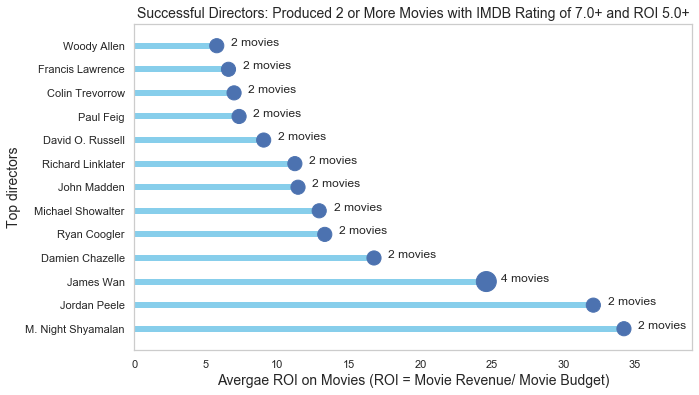

In [29]:
#Plotting graph

sizes = top_directors_roi['movies_count']
sizes1 = top_directors_roi['movies_count']*100

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.grid(b=None)
plt.xlim(0, 39)
plt.hlines(y="director_name", data= top_directors_roi, xmin=0, xmax=top_directors_roi['roi'], lw=6, color='skyblue', zorder = 1)
plt.scatter(top_directors_roi['roi'] + 0.2, top_directors_roi['director_name'], marker="o", s=sizes1)

plt.title("Successful Directors: Produced 2 or More Movies with IMDB Rating of 7.0+ and ROI 5.0+", size=14, loc='center')
plt.xlabel('Avergae ROI on Movies (ROI = Movie Revenue/ Movie Budget)', size=14)
plt.ylabel('Top directors', size=14) 

for i, txt in enumerate(sizes):
   plt.annotate(f'{txt:.0f} movies', (top_directors_roi['roi'].iloc[i] + 1.2, top_directors_roi['director_name'].iloc[i]))
    


The above graph shows top directors - those who produced 2+ successful movies over last 10 years. 

We recommend that Microsoft cooperates with these directors.

### Step 6: 

Let's now look at the most successful actors. 

In [36]:
#Pulling actors data

con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?', host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com', database = 'movies')
cur = con.cursor()

cur.execute("""SELECT *
                FROM movies.imdb_title_ratings
                JOIN movies.imdb_title_basics USING(tconst)
                JOIN movies.imdb_title_principals USING (tconst)
                JOIN movies.imdb_name_basics USING (nconst)
                WHERE imdb_title_basics.start_year >= 2010
                AND imdb_title_ratings.averagerating >7.0
                AND imdb_title_ratings.numvotes > 50;""")

df_act = pd.DataFrame(cur.fetchall())
df_act.columns = [x[0] for x in cur.description]
df_act

,nconst,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,ordering,category,job,characters,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0365480,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",1,actor,,"[""Joseph Briteman""]",Anthony Harrison,1961.0,NaN,"actor,writer,producer","tt5615700,tt0298814,tt0137204,tt6461824"
1,nm0003210,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",2,actor,,"[""Horst Himmelferger""]",C. Ernst Harth,1970.0,NaN,"actor,producer,soundtrack","tt0379725,tt1319743,tt0245674,tt0137204"
2,nm0367762,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",3,actress,,"[""Eva""]",Ellie Harvie,1965.0,NaN,"actress,writer,director","tt0172031,tt0899106,tt0808510,tt0216216"
3,nm0186322,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",4,actress,,"[""Pauline""]",Chilton Crane,NaN,NaN,actress,"tt0309593,tt1306980,tt0389564,tt0106179"
4,nm0153581,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",5,producer,producer,,Ron Chartier,NaN,NaN,"actor,producer,production_manager","tt0137204,tt0409459,tt0163596,tt0120667"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71996,nm1902682,tt9914286,8.70,136,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",5,writer,,,Kasim Uçkan,NaN,NaN,writer,"tt5373564,tt9914286,tt2865318,tt0456815"
71997,nm10569206,tt9914286,8.70,136,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",6,producer,producer,,Dilek Ölekli,NaN,NaN,,
71998,nm8744743,tt9914286,8.70,136,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",7,composer,,,Onder Samet Kok,NaN,NaN,"composer,sound_department,music_department","tt9174986,tt5084348,tt9139412,tt9668598"
71999,nm6314548,tt9914286,8.70,136,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8,cinematographer,,,Faik Can Akinci,NaN,NaN,"producer,cinematographer","tt4630064,tt3557492"


In [37]:
# Remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df_act['primary_title'] = df_act['primary_title'].str.replace(char, ' ')
    
#put Title in low caps
df_act['primary_title'] =  df_act['primary_title'].map(lambda x: x.lower())

df_act.head()

,nconst,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,ordering,category,job,characters,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0365480,tt0137204,8.10,263,joe finds grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",1,actor,,"[""Joseph Briteman""]",Anthony Harrison,1961.0,NaN,"actor,writer,producer","tt5615700,tt0298814,tt0137204,tt6461824"
1,nm0003210,tt0137204,8.10,263,joe finds grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",2,actor,,"[""Horst Himmelferger""]",C. Ernst Harth,1970.0,NaN,"actor,producer,soundtrack","tt0379725,tt1319743,tt0245674,tt0137204"
2,nm0367762,tt0137204,8.10,263,joe finds grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",3,actress,,"[""Eva""]",Ellie Harvie,1965.0,NaN,"actress,writer,director","tt0172031,tt0899106,tt0808510,tt0216216"
3,nm0186322,tt0137204,8.10,263,joe finds grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",4,actress,,"[""Pauline""]",Chilton Crane,NaN,NaN,actress,"tt0309593,tt1306980,tt0389564,tt0106179"
4,nm0153581,tt0137204,8.10,263,joe finds grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",5,producer,producer,,Ron Chartier,NaN,NaN,"actor,producer,production_manager","tt0137204,tt0409459,tt0163596,tt0120667"


In [39]:
left_join_df_act = df_join.merge(df_act, on='primary_title', how='left' )

df_join_act = left_join_df_act.dropna(subset = ["primary_name"])
df_join_act.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year,tconst_x,averagerating_x,...,genres_y,ordering,category,job,characters,primary_name,birth_year_y,death_year_y,primary_profession_y,known_for_titles_y
1,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,"Horror,Thriller",10.0,editor,,,Luke Ciarrocchi,NaN,NaN,"editorial_department,editor","tt6823368,tt1815862,tt4972582,tt0949731"
2,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,"Horror,Thriller",1.0,actor,,"[""Dennis"",""Patricia"",""Hedwig""]",James McAvoy,1979.0,NaN,"actor,soundtrack,producer","tt1450321,tt4972582,tt0783233,tt0455590"
3,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,"Horror,Thriller",2.0,actress,,"[""Casey Cooke""]",Anya Taylor-Joy,1996.0,NaN,actress,"tt4520364,tt4972582,tt4263482,tt6823368"
4,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,"Horror,Thriller",3.0,actress,,"[""Claire Benoit""]",Haley Lu Richardson,1995.0,NaN,actress,"tt5990474,tt6472976,tt4972582,tt1878870"
5,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,...,"Horror,Thriller",4.0,actress,,"[""Marcia""]",Jessica Sula,1994.0,NaN,actress,"tt2974556,tt0840196,tt4972582,tt5770620"


In [40]:
df_act_count = df_join_act.loc[(df_join_act['category'] == 'actor') |(df_join_act['category'] == 'actress')].groupby('primary_name').count().sort_values(by = 'roi', ascending = False) 
df_act_count = df_act_count.tconst_x.reset_index()
df_act_count = df_act_count.rename(columns={"tconst_x": "how_many_movies"})
df_act_count.how_many_movies.value_counts()

1    306
2     81
3     10
4      3
5      2
Name: how_many_movies, dtype: int64

In [42]:
df_act_count.head(10)

,primary_name,how_many_movies
0,Bradley Cooper,5
1,Octavia Spencer,5
2,John Goodman,4
3,Robert Downey Jr.,4
4,Jennifer Lawrence,4
5,Chris Evans,3
6,Emma Stone,3
7,Judi Dench,3
8,Mark Ruffalo,3
9,Michael B. Jordan,3


In [41]:
act_roi = round(left_join_df_act[['primary_name', 'roi']].groupby('primary_name').mean(),2)

In [43]:
top_actors_roi = df_act_count.join(act_roi,on = 'primary_name',lsuffix= "A", rsuffix= "B").sort_values("how_many_movies", ascending=False) 
top_actors_roi = top_actors_roi.head(15)
top_actors_roi = top_actors_roi.sort_values("roi", ascending=False) 
top_actors_roi

,primary_name,how_many_movies,roi
9,Michael B. Jordan,3,12.18
6,Emma Stone,3,12.04
13,Keira Knightley,3,10.80
1,Octavia Spencer,5,10.52
12,Jason Bateman,3,10.13
2,John Goodman,4,9.99
7,Judi Dench,3,9.09
0,Bradley Cooper,5,8.99
10,Ryan Reynolds,3,8.76
4,Jennifer Lawrence,4,8.21


In [47]:
print(f'There are {len(top_actors_roi)} actors who produced 3 or more successful movies over last 10 years')

There are 15 actors who produced 3 or more successful movies over last 10 years


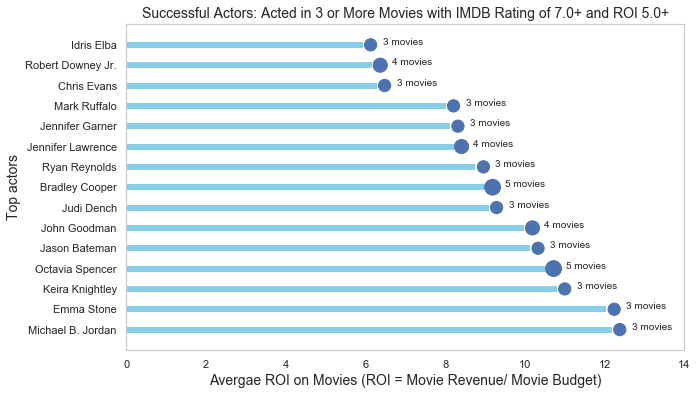

In [45]:
#Plotting graph
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

sizes2 = top_actors_roi['how_many_movies']
sizes3 = top_actors_roi['how_many_movies']*50


f, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.grid(b=None)
plt.xlim(0, 14)
plt.hlines(y="primary_name", data= top_actors_roi, xmin=0, xmax=top_actors_roi['roi'], lw=6, color='skyblue', zorder = 1)
plt.scatter(top_actors_roi['roi'] + 0.2, top_actors_roi['primary_name'], marker="o", s=sizes3)

plt.title("Successful Actors: Acted in 3 or More Movies with IMDB Rating of 7.0+ and ROI 5.0+", size=14, loc='center', zorder = 2)
plt.xlabel('Avergae ROI on Movies (ROI = Movie Revenue/ Movie Budget)', size=14)
plt.ylabel('Top actors', size=14) 

for i, txt in enumerate(sizes2):
   plt.annotate(f'{txt:.0f} movies', (top_actors_roi['roi'].iloc[i] +0.5, top_actors_roi['primary_name'].iloc[i]))
    


There are 15 actors that acted in three or more successful movies over last 10 years. 

We recommend that Microsoft cooperates with these actors.